In [ ]:
import pandas as pd
import numpy as np
import requests
%pip install Tiingo
from tiingo import TiingoClient
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as lr
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr, t, norm
from scipy.interpolate import CubicSpline
from scipy.optimize import newton
from datetime import datetime
import seaborn as sns
from google.colab import drive
import re
import scipy
from scipy import stats
import math
from math import atanh, pow
from numpy import tanh
pd.options.display.max_columns = None
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Make Yield Curve

In [ ]:
def make_time_series(df):
    for col in df.columns:
      if 'date' in col.lower():
        col_rename = 'date'
        df.rename(columns={col: col_rename}, inplace=True)
    datestring = '00:00:00+00:00'
    df['date'] = df['date'] + ' ' + datestring

    if df['date'].dtype == 'object':
      try:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z')
      except ValueError:
        print('Converting "date" column to datetime format')
        df['date'] = pd.to_datetime(df['date'])
      df = df.set_index('date')
    return df

In [ ]:
t_rates = pd.read_csv('gdrive/My Drive/daily-treasury-rates.csv')
t_rates = make_time_series(t_rates)
t_rates

Converting "date" column to datetime format


,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
date,,,,,,,,,,,,,
2024-06-25 00:00:00+00:00,5.43,5.46,5.49,5.44,5.37,5.10,4.65,4.45,4.25,4.23,4.23,4.46,4.36
2024-06-24 00:00:00+00:00,5.42,5.46,5.50,5.45,5.37,5.10,4.71,4.46,4.27,4.25,4.25,4.48,4.38
2024-06-21 00:00:00+00:00,5.42,5.46,5.49,5.45,5.36,5.10,4.70,4.45,4.26,4.25,4.25,4.49,4.39
2024-06-20 00:00:00+00:00,5.42,5.46,5.50,5.46,5.37,5.10,4.70,4.45,4.26,4.25,4.25,4.49,4.39
2024-06-18 00:00:00+00:00,5.40,5.46,5.50,5.45,5.37,5.09,4.69,4.43,4.24,4.22,4.22,4.47,4.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00+00:00,5.54,5.48,5.49,5.39,5.24,4.82,4.36,4.11,3.97,3.99,4.01,4.33,4.17
2024-01-05 00:00:00+00:00,5.54,5.48,5.47,5.41,5.24,4.84,4.40,4.17,4.02,4.04,4.05,4.37,4.21
2024-01-04 00:00:00+00:00,5.56,5.48,5.48,5.41,5.25,4.85,4.38,4.14,3.97,3.99,3.99,4.30,4.13


In [ ]:
#Make maturities
yields = np.array(np.log([1 + (i / 100) for i in t_rates.iloc[31]]))
maturities = np.array([1/12, 1/6, .25, .3333, .5, 1, 2, 3, 5, 7, 10, 20, 30])

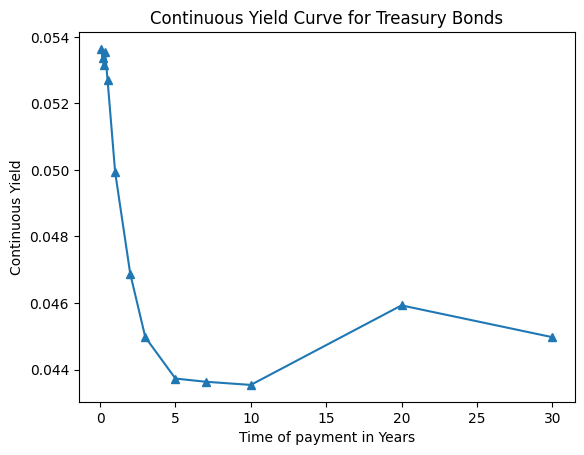

In [ ]:
#Plot treasury Yield Curve
plt.plot(maturities, yields, '-^')
plt.xlabel('Time of payment in Years')
plt.ylabel('Continuous Yield')
plt.title('Continuous Yield Curve for Treasury Bonds')
plt.show()

In [ ]:
#Make interpolations of yield curve

def make_interpolations(par_yields, maturities, coupon_freq):
  counts = 1 / coupon_freq
  yields_cont = np.array(np.log([1 + (i / 100) for i in par_yields]))
  maturities_freq = maturities * coupon_freq
  cs = CubicSpline(maturities_freq, yields_cont)
  new_maturities_freq = np.arange(min(maturities_freq), max(maturities_freq) + 1, 1)
  maturities_yr = new_maturities_freq / coupon_freq
  new_yields = cs(new_maturities_freq)

  df = pd.DataFrame({
    'Maturities freq' : new_maturities_freq,
    'Yields' : new_yields
    })
  df['Maturities freq'] = counts * (df.index + 1)
  return df

In [ ]:
df = make_interpolations(t_rates.iloc[31], maturities, 4)
df = df[:-1]
df

,Maturities freq,Yields
0,0.25,0.053636
1,0.50,0.053541
2,0.75,0.052046
3,1.00,0.050624
4,1.25,0.049618
...,...,...
115,29.00,0.045628
116,29.25,0.045504
117,29.50,0.045371
118,29.75,0.045229


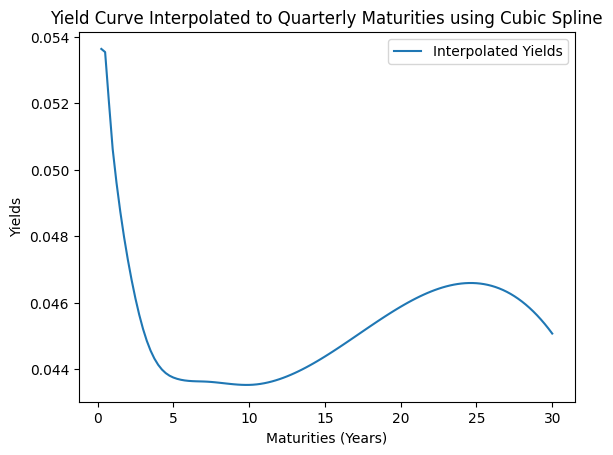

In [ ]:
#Plot new interpolated yield curve
plt.plot(df['Maturities freq'], df['Yields'], '-', label='Interpolated Yields')
plt.xlabel('Maturities (Years)')
plt.ylabel('Yields')
plt.title('Yield Curve Interpolated to Quarterly Maturities using Cubic Spline')
plt.legend()
plt.show()

In [ ]:
#Make bond class
class Bond:

  def __init__(self,
               principal,
               current_price,
               coupon_rate,
               maturity_date,
               issue_date,
               yield_curve_maturities,
               yield_curve_rates,
               payment_frequency):

    self.principal = principal
    self.current_price = current_price
    self.coupon_rate = coupon_rate
    self.maturity_date = maturity_date
    self.issue_date = issue_date
    self.payment_frequency = payment_frequency
    self.yield_curve_maturities = yield_curve_maturities
    self.yield_curve_rates = yield_curve_rates
    self.interpolated_yields, self.new_maturities_freq = self._interpolate_yields()
    self.cashflows = self._cashflows()

  def _interpolate_yields(self):
    yields_cont = np.array(np.log([1 + (i / 100) for i in self.yield_curve_rates]))
    maturities_freq = self.yield_curve_maturities * self.payment_frequency
    cs = CubicSpline(maturities_freq, yields_cont)
    new_maturities_freq = np.arange(min(maturities_freq), max(maturities_freq) + 1, 1)
    maturities_yr = new_maturities_freq / self.payment_frequency
    new_yields = cs(new_maturities_freq)
    new_maturities_freq = np.array([.25 * (i + 1) for i in range(len(new_maturities_freq))])
    new_maturities_freq = new_maturities_freq[:-1]
    return np.array(new_yields), new_maturities_freq

  def _cashflows(self):
    cash_flows = [self.coupon_rate * self.principal] * len(self.new_maturities_freq)
    cash_flows[-1] = cash_flows[-1] + self.principal
    return cash_flows

  def present_value(self):
    pv = sum([c / ((1 + r) ** m) for c,r,m in zip(self.cashflows, self.interpolated_yields, self.new_maturities_freq)])
    return pv

  def make_discount_factor(self):
    discount_factor = [math.exp(-r * t) for r,t in zip(self.interpolated_yields, self.new_maturities_freq)]
    plt.plot(self.new_maturities_freq, discount_factor, '-', label='Interpolated Yields')
    plt.xlabel('Maturities (Years)')
    plt.ylabel('Discount Factor')
    plt.title('Discount Factor Structure')
    plt.legend()
    plt.show()

  def ytm(self, intial_guess = 0.01):

    def bond_equation(y):
      price = sum([cf * np.exp(-y * t) for cf, t in zip(self.cashflows, self.new_maturities_freq)])
      return price - self.current_price

    ytm_continuous = newton(bond_equation, intial_guess)
    return ytm_continuous

  def duration(self):
    ytm_continuous = self.ytm()
    pv_cash_flows = [cf * np.exp(-ytm_continuous * t ) for cf, t in zip(self.cashflows, self.new_maturities_freq)]
    pv_total = sum(pv_cash_flows)
    duration = sum(t * pv for t, pv in zip(self.new_maturities_freq, pv_cash_flows)) / 100
    return duration

  def convexity(self):
    ytm_continuous = self.ytm()
    pv_cash_flows = [cf * np.exp(-ytm_continuous * t) for cf, t in zip(self.cashflows, self.new_maturities_freq)]
    pv_total = sum(pv_cash_flows)
    convexity = sum((t ** 2) * pv for t, pv in zip(self.new_maturities_freq, pv_cash_flows)) / 10000
    return convexity

  def plot_duration_convexity(self, yield_changes=None):
        if yield_changes is None:
            yield_changes = np.linspace(-0.01, 0.01, 100)

        initial_price = self.current_price
        ytm_continuous = self.ytm()

        actual_prices = []
        linear_approx_prices = []
        quadratic_approx_prices = []

        for dy in yield_changes:
            new_ytm = ytm_continuous + dy
            new_price = sum([cf * np.exp(-new_ytm * t) for cf, t in zip(self.cashflows, self.new_maturities_freq)])
            actual_prices.append(new_price)

            duration = self.duration()
            linear_approx_price = initial_price - (duration * initial_price * dy)
            linear_approx_prices.append(linear_approx_price)

            convexity = self.convexity()
            quadratic_approx_price = linear_approx_price + (0.5 * convexity * initial_price * (dy ** 2))
            quadratic_approx_prices.append(quadratic_approx_price)

        plt.figure(figsize=(10, 6))
        plt.plot(yield_changes, actual_prices, label='Actual Prices', color='black')
        plt.plot(yield_changes, linear_approx_prices, label='Linear Approximation (Duration)', linestyle='--', color='green')
        plt.plot(yield_changes, quadratic_approx_prices, label='Quadratic Approximation (Duration + Convexity)', linestyle=':', color='red')
        plt.xlabel('Yield Change')
        plt.ylabel('Bond Price')
        plt.title('Bond Price vs Yield Change')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
issue_date = pd.to_datetime('2015-06-01')
maturity_date = pd.to_datetime('2035-06-01')
bond = Bond(principal= 100,
            current_price= 101.529,
            coupon_rate= 0.052,
            maturity_date= maturity_date,
            issue_date= issue_date,
            yield_curve_maturities= maturities,
            yield_curve_rates= t_rates.iloc[31],
            payment_frequency=4)

In [ ]:
bond.present_value()

370.4560287397963

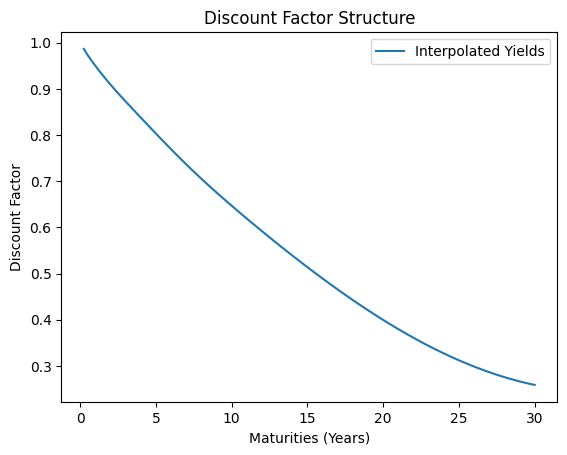

In [ ]:
bond.make_discount_factor()

In [ ]:
bond.ytm()

0.1997864181662943

In [ ]:
bond.duration()

5.1958962847916395

In [ ]:
bond.convexity()

0.5122254870643165

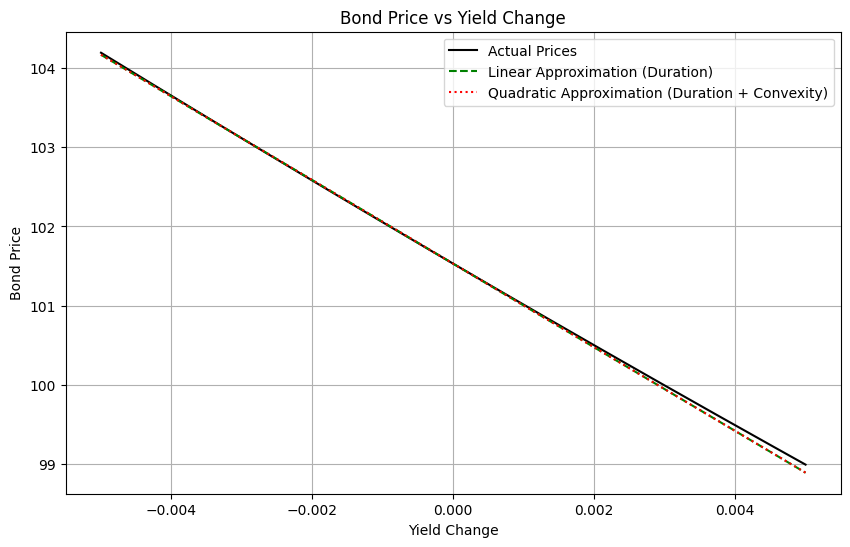

In [ ]:
custom_yield_changes = np.linspace(-0.005, 0.005, 200)
bond.plot_duration_convexity(yield_changes= custom_yield_changes)